# INF367 - Exercise 4
- Deadline: Sunday, 15.09.19, 23.59
- Submission details: Computer written or scanned pages. 
- Deliver here: MittUIB.no/assignments

Weekly exercises are a compulsory part of the course. You will need to complete at least half of the exercises to be eligible for the examination. Exercises need to be submitted to MittUIB.no/assignments before 23.59 on Sundays. They will then be reviewed, and each exercise will be accepted as completed if we see you have made an effort. 

## Exercise 1. Density-based anomaly detection

Use the below dataset and detect anomalies based on 
- Kernel density estimator (you may use `sklearn.neighbors.KernelDensity`), 
- Gaussian mixture model (you may use `sklearn.mixture.GaussianMixture`). 

Calculate the AUC for both methods (you may use `sklearn.metrics.auc`).

In [1]:
%load_ext nb_black
%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

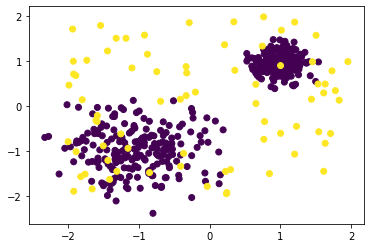

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

%matplotlib inline

# Parameters
n_samples = 500
anomaly_fraction = 0.15
n_anomaly = int(anomaly_fraction * n_samples)

# Generate data
rng = np.random.RandomState(1)
data = np.vstack(
    (
        make_blobs(
            centers=[[-1, -1], [1, 1]],
            cluster_std=[0.5, 0.2],
            n_samples=n_samples - n_anomaly,
            n_features=2,
            random_state=0,
        )[0],
        rng.uniform(low=-2, high=2, size=(n_anomaly, 2)),
    )
)
true_anomalies = np.repeat((0, 1), (n_samples - n_anomaly, n_anomaly))

# plot
plt.scatter(data[:, 0], data[:, 1], c=true_anomalies)
plt.show()

### Exercise 1 - solution

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from sklearn.metrics import auc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

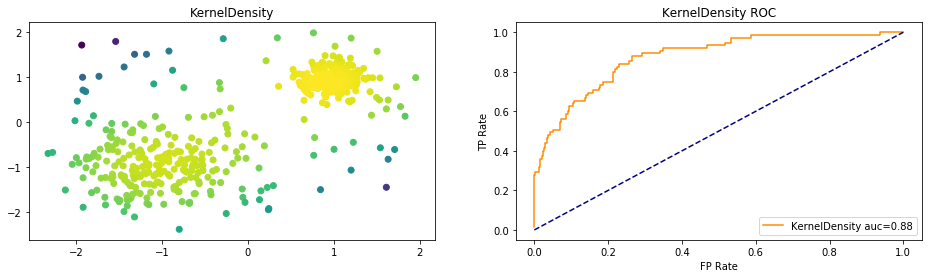

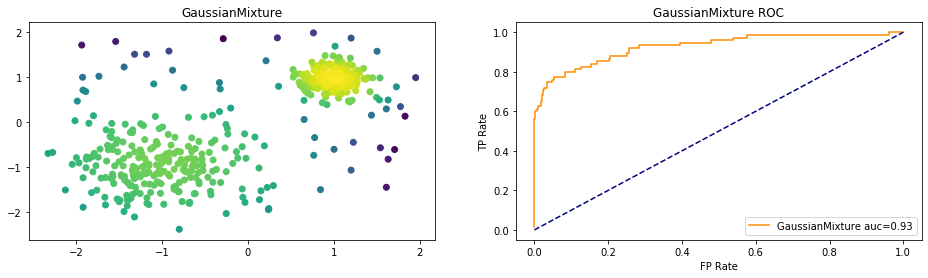

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
for index, model in enumerate((KernelDensity(), GaussianMixture(n_components=2))):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    name = type(model).__name__

    model.fit(data)

    scores = model.score_samples(data)

    ax[0].scatter(data[:, 0], data[:, 1], c=scores)
    ax[0].set_title(name)

    tp_rate = np.cumsum(true_anomalies[np.argsort(scores)]) / np.sum(true_anomalies)
    fp_rate = np.cumsum(true_anomalies[np.argsort(scores)] == 0) / np.sum(
        true_anomalies == 0
    )

    auc_score = auc(fp_rate, tp_rate)

    ax[1].plot(
        fp_rate,
        tp_rate,
        color="darkorange",
        label=f"{name} auc={auc(fp_rate, tp_rate):.2f}",
    )
    ax[1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[1].set_xlabel("FP Rate")
    ax[1].set_ylabel("TP Rate")
    ax[1].set_title(f"{name} ROC")
    ax[1].legend(loc="lower right")

    plt.show()

## Exercise 2. LODA paper

Carefully read the paper on LODA <cite data-cite="LODA">(Pevný, 2015)</cite>.

1. What is the rational behind using an online anomaly detection algorithm?
2. Explain how the LODA algorithm deals with missing data. 
3. State the advantages of using random projections.
4. Give a short overview over histogram methods considered in the LODA paper. 

### Exercise 2 - solution

1. Learning without loading whole training data at once
2. Output is calculated from histograms, which are ingoring missing variable (0 value in $w_i$)
3. 
    * Random projections in Loda are used to project he input space into a single dimension, which simplifies the complexity of all operations over it.
    * Random projections consistently improve the performance

## Exercise 3. LODA algorithm and application

- Implement a simplified offline version of the LODA algorithm using the number of histograms and the number of histogram bins as hyperparameters. You may find the functions `numpy.histogram` or `scipy.stats.rv_histogram` useful.

- Apply the above algorithm on the sample data below with different numbers of histograms and numbers of bins per histogram, and calculate the AUC. 

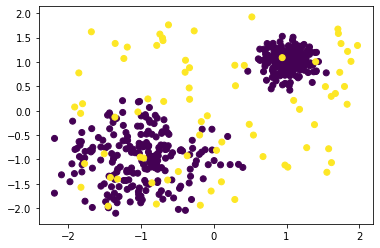

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

%matplotlib inline

# Parameters
n_samples = 500
n_dims = 16
anomaly_fraction = 0.15
n_anomaly = int(anomaly_fraction * n_samples)

# Generate data
rng = np.random.RandomState(1)
data = np.vstack(
    (
        make_blobs(
            centers=[np.repeat(-1, n_dims), np.repeat(1, n_dims)],
            cluster_std=[0.5, 0.2],
            n_samples=n_samples - n_anomaly,
            n_features=n_dims,
            random_state=0,
        )[0],
        rng.uniform(low=-2, high=2, size=(n_anomaly, n_dims)),
    )
)
true_anomalies = np.repeat((0, 1), (n_samples - n_anomaly, n_anomaly))

# plot
plt.scatter(data[:, 0], data[:, 1], c=true_anomalies)
plt.show()

### Exercise 3 - solution

In [6]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Union

import numpy as np
import scipy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
@dataclass
class SimpleLODA:
    """ Simplified LODA

    LODA: Lightweight on-line detector of anomalies
    https://link.springer.com/article/10.1007/s10994-015-5521-0
    """

    k: int
    bins: Union[int, str]
    d: int

    def __post_init__(self):
        self.weights = np.zeros((self.k, self.d))

        non_zero_w = np.rint(self.d * (self.d ** (-1 / 2))).astype(int)

        indexes = np.random.rand(self.k, self.d).argpartition(non_zero_w, axis=1)[
            :, :non_zero_w
        ]

        rand_values = np.random.normal(size=indexes.shape)

        for weight, chosen_d, values in zip(self.weights, indexes, rand_values):
            weight[chosen_d] = values

    def fit(self, X: np.ndarray) -> SimpleLODA:
        w_X = X @ self.weights.T

        self.hists = [
            scipy.stats.rv_histogram(np.histogram(w_x, bins=self.bins)) for w_x in w_X.T
        ]

        return self

    def score_samples(self, X: np.ndarray) -> np.ndarray:
        w_X = X @ self.weights.T

        X_prob = np.array([hist.pdf(w_x) for hist, w_x in zip(self.hists, w_X.T)])
        X_prob[X_prob <= 0] = X_prob[X_prob > 0].min()

        X_scores = -np.mean(np.log(X_prob), axis=0)

        return -X_scores

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

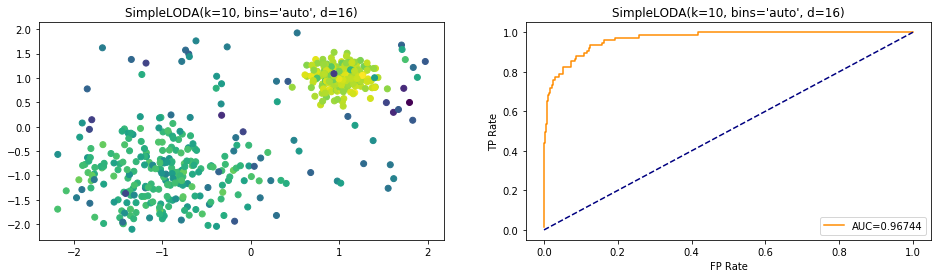

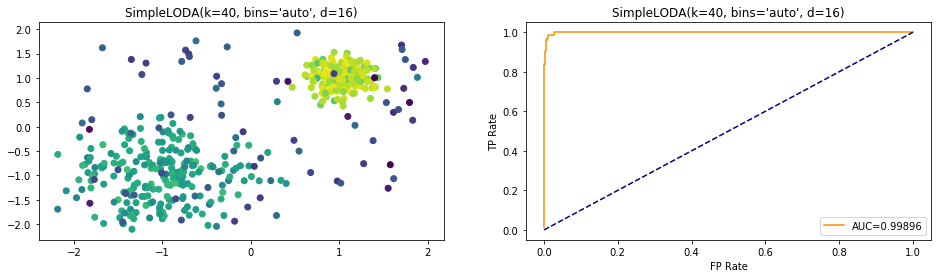

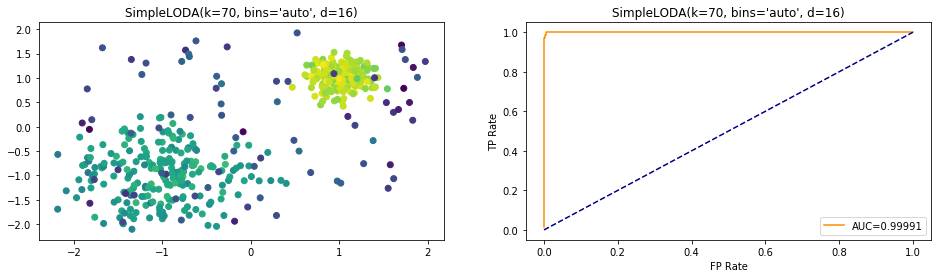

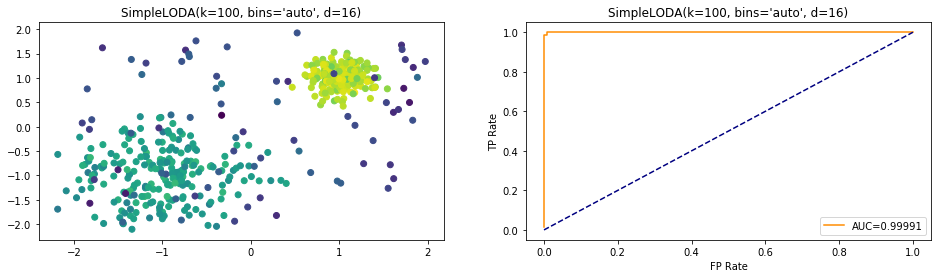

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
for index, model in enumerate(
    [SimpleLODA(k=k, d=data.shape[1], bins="auto") for k in range(10, 101, 30)]
):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    name = str(model)

    model.fit(data)

    scores = model.score_samples(data)

    ax[0].scatter(data[:, 0], data[:, 1], c=scores)
    ax[0].set_title(name)

    tp_rate = np.cumsum(true_anomalies[np.argsort(scores)]) / np.sum(true_anomalies)
    fp_rate = np.cumsum(true_anomalies[np.argsort(scores)] == 0) / np.sum(
        true_anomalies == 0
    )

    auc_score = auc(fp_rate, tp_rate)

    ax[1].plot(
        fp_rate, tp_rate, color="darkorange", label=f"AUC={auc(fp_rate, tp_rate):.5f}"
    )
    ax[1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[1].set_xlabel("FP Rate")
    ax[1].set_ylabel("TP Rate")
    ax[1].set_title(f"{name}")
    ax[1].legend(loc="lower right")

    plt.show()